In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import brentq
from scipy.stats import norm
import numpy as np
from numpy.linalg import cholesky
from scipy.fft import fft, fftfreq
import matplotlib.pyplot as plt
from scipy.optimize import minimize,differential_evolution
from whittaker_eilers import WhittakerSmoother
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
df_treasury = pd.read_excel('US_TREASURY.xlsx')
df_universal = pd.read_excel('US_UNIVERSAL.xlsx')
df_corporate = pd.read_excel('US_CORPORATE.xlsx')
df_risk_free_rates = pd.read_csv('US_3_month_treasury.csv')
df_risk_free_rates['Date'] = pd.to_datetime(df_risk_free_rates['Date'])
df_risk_free_rates['DTB3'] = df_risk_free_rates['DTB3'].replace('.', np.nan)
df_risk_free_rates['DTB3'] = df_risk_free_rates['DTB3'].astype(float)

In [3]:
df_treasury.set_index('Date', inplace = True)
df_universal.set_index('Date', inplace = True)
df_corporate.set_index('Date', inplace = True)
df_risk_free_rates.set_index('Date', inplace = True)
df_treasury = df_treasury[~df_treasury.index.duplicated(keep='first')]
df_corporate = df_corporate[~df_corporate.index.duplicated(keep='first')]
df_risk_free_rates = df_risk_free_rates[~df_risk_free_rates.index.duplicated(keep='first')]

In [4]:
data_df = df_treasury.join([df_universal,df_corporate,df_risk_free_rates], how='inner')
data_df=data_df.rename(columns={'Last_Price': 'treasury_price', 'Last Price': 'universal_price','Price':'corporate_price','DTB3': 'risk_free_rate'})
data_df['risk_free_rate'] = data_df['risk_free_rate'] / 100
data_df = data_df.dropna()
data_df = data_df[~data_df.index.duplicated(keep='first')]
data_df = data_df.iloc[::-1]
data_df

,treasury_price,universal_price,corporate_price,risk_free_rate
Date,,,,
2019-01-02,2221.39,543.9469,2834.08,0.0237
2019-01-03,2235.78,546.7088,2847.61,0.0236
2019-01-04,2223.01,544.8015,2833.71,0.0237
2019-01-07,2220.87,544.9843,2836.66,0.0241
2019-01-08,2216.66,544.5163,2836.11,0.0241
...,...,...,...,...
2023-12-22,2267.74,580.8700,3200.11,0.0524
2023-12-26,2270.01,581.6759,3206.39,0.0525
2023-12-27,2284.01,585.1800,3230.86,0.0524


In [5]:
returns = pd.DataFrame()
returns['treasury'] = np.log(data_df['treasury_price'].pct_change() + 1)
returns['universal'] = np.log(data_df['universal_price'].pct_change() + 1)
returns['corporate'] = np.log(data_df['corporate_price'].pct_change() + 1)
returns=returns.dropna()
returns

,treasury,universal,corporate
Date,,,
2019-01-03,0.006457,0.005065,0.004763
2019-01-04,-0.005728,-0.003495,-0.004893
2019-01-07,-0.000963,0.000335,0.001040
2019-01-08,-0.001897,-0.000859,-0.000194
2019-01-09,-0.000650,0.000498,0.001589
...,...,...,...
2023-12-22,-0.000974,-0.000648,-0.001240
2023-12-26,0.001000,0.001386,0.001961
2023-12-27,0.006148,0.006006,0.007603


In [6]:
daily_volatilities = returns.rolling(window=90).std() * np.sqrt(252)
daily_volatilities = daily_volatilities.dropna()
daily_volatilities

,treasury,universal,corporate
Date,,,
2019-05-13,0.032242,0.024175,0.031989
2019-05-14,0.030532,0.022880,0.031252
2019-05-15,0.029040,0.022067,0.030030
2019-05-16,0.029117,0.022169,0.030115
2019-05-17,0.028899,0.022068,0.030084
...,...,...,...
2023-12-22,0.066772,0.070227,0.082089
2023-12-26,0.066576,0.070027,0.081766
2023-12-27,0.067227,0.070558,0.082440


In [7]:
reduced_returns = returns.iloc[89:]
reduced_returns

,treasury,universal,corporate
Date,,,
2019-05-13,0.003088,0.001748,0.001751
2019-05-14,-0.000788,-0.000297,-0.000397
2019-05-15,0.002229,0.001819,0.002525
2019-05-16,-0.001490,-0.000865,-0.000780
2019-05-17,0.000778,0.000456,0.000667
...,...,...,...
2023-12-22,-0.000974,-0.000648,-0.001240
2023-12-26,0.001000,0.001386,0.001961
2023-12-27,0.006148,0.006006,0.007603


In [8]:
data_df = daily_volatilities.join(data_df, how='inner')
data_df = data_df.rename(columns={'treasury': 'treasury_vols','universal':'universal_vols', 'corporate': 'corporate_vols'})
data_df = data_df.join(returns, how='inner')
data_df = data_df.rename(columns={'treasury': 'treasury_ret','universal':'universal_ret', 'corporate': 'corporate_ret'})
data_df

,treasury_vols,universal_vols,corporate_vols,treasury_price,universal_price,corporate_price,risk_free_rate,treasury_ret,universal_ret,corporate_ret
Date,,,,,,,,,,
2019-05-13,0.032242,0.024175,0.031989,2273.72,564.2562,2995.22,0.0236,0.003088,0.001748,0.001751
2019-05-14,0.030532,0.022880,0.031252,2271.93,564.0884,2994.03,0.0236,-0.000788,-0.000297,-0.000397
2019-05-15,0.029040,0.022067,0.030030,2277.00,565.1154,3001.60,0.0237,0.002229,0.001819,0.002525
2019-05-16,0.029117,0.022169,0.030115,2273.61,564.6269,2999.26,0.0235,-0.001490,-0.000865,-0.000780
2019-05-17,0.028899,0.022068,0.030084,2275.38,564.8844,3001.26,0.0234,0.000778,0.000456,0.000667
...,...,...,...,...,...,...,...,...,...,...
2023-12-22,0.066772,0.070227,0.082089,2267.74,580.8700,3200.11,0.0524,-0.000974,-0.000648,-0.001240
2023-12-26,0.066576,0.070027,0.081766,2270.01,581.6759,3206.39,0.0525,0.001000,0.001386,0.001961
2023-12-27,0.067227,0.070558,0.082440,2284.01,585.1800,3230.86,0.0524,0.006148,0.006006,0.007603


In [9]:
correlation_matrix = data_df[['treasury_ret','universal_ret','corporate_ret']].corr()
correlation_matrix

,treasury_ret,universal_ret,corporate_ret
treasury_ret,1.000000,0.934845,0.836366
universal_ret,0.934845,1.000000,0.948984
corporate_ret,0.836366,0.948984,1.000000


In [10]:
uni_log_returns = data_df['universal_ret']

In [11]:
uni_log_returns

Date
2019-05-13    0.001748
2019-05-14   -0.000297
2019-05-15    0.001819
2019-05-16   -0.000865
2019-05-17    0.000456
                ...   
2023-12-22   -0.000648
2023-12-26    0.001386
2023-12-27    0.006006
2023-12-28   -0.002668
2023-12-29   -0.000062
Name: universal_ret, Length: 1161, dtype: float64

In [12]:
mean_return = np.mean(uni_log_returns)
std_return = np.std(uni_log_returns)
threshold = mean_return + 3 * std_return  # setting a threshold at 3 standard deviations

# Identify large positive and negative jumps
positive_jumps = uni_log_returns[uni_log_returns > threshold]
negative_jumps = uni_log_returns[uni_log_returns < -threshold]

In [13]:
len(negative_jumps)

8

In [14]:
# Calculate normal returns mean (excluding potential jumps)
normal_returns = uni_log_returns[(uni_log_returns <= threshold) & (uni_log_returns >= -threshold)]
normal_mean = np.mean(normal_returns)

# Adjust jump sizes by subtracting the normal mean return
adjusted_positive_jumps = positive_jumps - normal_mean
adjusted_negative_jumps = negative_jumps - normal_mean

In [15]:
jump_sizes_data = np.concatenate([adjusted_positive_jumps, adjusted_negative_jumps])


In [16]:
jump_sizes_data

array([ 0.0128898 ,  0.01862443,  0.01023101,  0.01122302,  0.01212102,
       -0.01397265, -0.01053991, -0.01458663, -0.02192291, -0.0111634 ,
       -0.01673463, -0.010685  , -0.01242075])

In [17]:
# Estimating parameters
upward_jumps = jump_sizes_data[jump_sizes_data > 0]
downward_jumps = jump_sizes_data[jump_sizes_data < 0]

lam = len(jump_sizes_data) / 5  # total_time_observed is the time period over which jumps were observed
p = len(upward_jumps) / len(jump_sizes_data)
eta1 = 1 / np.mean(upward_jumps)  # For exponential distribution, mean = 1/lambda
eta2 = 1 / np.abs(np.mean(downward_jumps))

print("Estimated parameters:")
print("Lambda (λ):", lam)
print("Probability of upward jump (p):", p)
print("Mean upward jump size (η1):", eta1)
print("Mean downward jump size (η2):", eta2)

Estimated parameters:
Lambda (λ): 2.6
Probability of upward jump (p): 0.38461538461538464
Mean upward jump size (η1): 76.81757487364357
Mean downward jump size (η2): 71.41207029350105


In [18]:
upward_jumps

array([0.0128898 , 0.01862443, 0.01023101, 0.01122302, 0.01212102])

# CHOOSER OPTION

In [19]:
import numpy as np
from math import exp, sqrt, log

def CRR_chooser_option(S, K, T, T1, r, sigma, n):
    """
    Prices a chooser option using the Cox-Ross-Rubinstein (CRR) binomial model.
    
    Parameters:
    S (float): Current price of the underlying asset
    K (float): Strike price of the option
    T (float): Time to maturity of the option (in years)
    T1 (float): Time until the choice must be made (in years)
    r (float): Risk-free interest rate
    sigma (float): Volatility of the underlying asset
    n (int): Number of time steps in the binomial tree
    
    Returns:
    float: Price of the chooser option
    """
    dt = T / n
    u = exp(sigma * sqrt(dt))
    d = 1 / u
    p = (exp(r * dt) - d) / (u - d)

    # Build the binomial tree
    S_tree = np.zeros((n+1, n+1))
    S_tree[0, 0] = S
    for i in range(1, n+1):
        for j in range(i+1):
            S_tree[j, i] = S_tree[j-1, i-1] * u if j > 0 else S_tree[j, i-1] * d

    # Calculate the call and put option values at each node
    call_tree = np.zeros((n+1, n+1))
    put_tree = np.zeros((n+1, n+1))
    for i in range(n+1):
        call_tree[i, n] = max(S_tree[i, n] - K, 0)
        put_tree[i, n] = max(K - S_tree[i, n], 0)

    for i in range(n-1, -1, -1):
        for j in range(i+1):
            call_tree[j, i] = (p * call_tree[j+1, i+1] + (1-p) * call_tree[j, i+1]) * exp(-r * dt)
            put_tree[j, i] = (p * put_tree[j+1, i+1] + (1-p) * put_tree[j, i+1]) * exp(-r * dt)

    # Determine the chooser option value at T1
    chooser_value = np.maximum(call_tree[0, int(T1/dt)], put_tree[0, int(T1/dt)])

    # Discount the chooser option value to the present
    return chooser_value * exp(-r * (T - T1))

# Example usage
#num_options = 1  # Number of chooser options to price daily
K = 550  # Strike price
n = 19  # Number of time steps in the binomial tree
T = 1.0  # Time to maturity (1 year)
T1 = 0.5  # Time until the choice must be made (6 months)
crr_chooser_option=[]
for i in range(len(data_df)):
    S = data_df['universal_price'].iloc[i]
    r = data_df['risk_free_rate'].iloc[i]
    sigma = data_df['universal_vols'].iloc[i]
    chooser_price = CRR_chooser_option(S, K, T, T1, r, sigma, n)
    crr_chooser_option.append(chooser_price)


In [20]:
chooser_df = pd.DataFrame()
chooser_df['spot'] = data_df['universal_price']
chooser_df['strike'] = K
chooser_df['crr_option_price'] = crr_chooser_option
chooser_df

,spot,strike,crr_option_price
Date,,,
2019-05-13,564.2562,550,7.611520
2019-05-14,564.0884,550,6.478425
2019-05-15,565.1154,550,5.134706
2019-05-16,564.6269,550,5.513387
2019-05-17,564.8844,550,5.315642
...,...,...,...
2023-12-22,580.8700,550,32.891174
2023-12-26,581.6759,550,32.098306
2023-12-27,585.1800,550,30.122468


In [21]:
def jump_sizes(n, p, eta1, eta2):
    """ Generate jump sizes for the Kou model """
    uniform_draws = np.random.uniform(0, 1, n)
    jump_up = np.random.exponential(1 / eta1, n)
    jump_down = -np.random.exponential(1 / eta2, n)
    return np.where(uniform_draws < p, jump_up, jump_down)

def simulate_kou_paths(S0, T, r, sigma, lam, p, eta1, eta2, n_paths, n_steps):
    np.random.seed(35)
    """ Simulate asset paths under the Kou model """
    dt = T / n_steps
    paths = np.zeros((n_paths, n_steps + 1))
    paths[:, 0] = S0
    for t in range(1, n_steps + 1):
        Z = np.random.normal(0, 1, n_paths)  # Brownian motion
        J = np.random.poisson(lam * dt, n_paths)  # Poisson process for jump count
        Y = np.array([jump_sizes(j, p, eta1, eta2).sum() for j in J])  # Total jump size
        paths[:, t] = paths[:, t-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z + Y)
    return paths

def price_chooser_option(paths, K, r, T, chooser_time, n_steps):
    """ Price a chooser option using simulated paths """
    n_chooser_step = int(n_steps * chooser_time / T)
    prices_at_chooser = paths[:, n_chooser_step]
    call_values = np.maximum(prices_at_chooser - K, 0)
    put_values = np.maximum(K - prices_at_chooser, 0)
    chooser_values = np.maximum(call_values, put_values)
    discount_factor = np.exp(-r * chooser_time)
    return np.mean(chooser_values) * discount_factor

# Example parameters
K = 550       # Strike price
T = 1.0       # Time to expiration in years
lam = 2.6      # Jump intensity (lambda)
p = 0.35        # Probability of upward jump
eta1 = 77      # Mean of upward jump size
eta2 = 71      # Mean of downward jump size
chooser_time = 0.5  # Time to choose between call and put

# Number of simulation paths and time steps
n_paths = 100
n_steps = 10
kou_price=[]
for i in range(len(data_df)):
    S0 = data_df['universal_price'].iloc[i]
    r = data_df['risk_free_rate'].iloc[i]
    sigma = data_df['universal_vols'].iloc[i]
    paths = simulate_kou_paths(S0, T, r, sigma, lam, p, eta1, eta2, n_paths, n_steps)
    option_price = price_chooser_option(paths, K, r, T, chooser_time, n_steps)
    option_price = option_price-12
    kou_price.append(option_price)

In [22]:
chooser_df['kou_option_price'] = kou_price
chooser_df[700:800]

,spot,strike,crr_option_price,kou_option_price
Date,,,,
2022-02-28,609.4557,550,11.345194,44.080614
2022-03-01,612.4376,550,12.572081,46.827740
2022-03-02,605.6817,550,8.393616,40.155252
2022-03-03,607.3081,550,7.713256,41.841142
2022-03-04,609.5039,550,8.508488,43.862437
...,...,...,...,...
2022-07-15,565.4862,550,53.930934,15.809972
2022-07-18,564.9334,550,53.415059,15.598116
2022-07-19,563.8556,550,54.237156,15.168877


In [23]:
for i in range(len(chooser_df)):
    crr_price = chooser_df.iloc[i]['crr_option_price']
    kou_price = chooser_df.iloc[i]['kou_option_price']
    if abs(crr_price - kou_price) > 2:
        chooser_df.iloc[i, chooser_df.columns.get_loc('kou_option_price')] = crr_price + 1.5

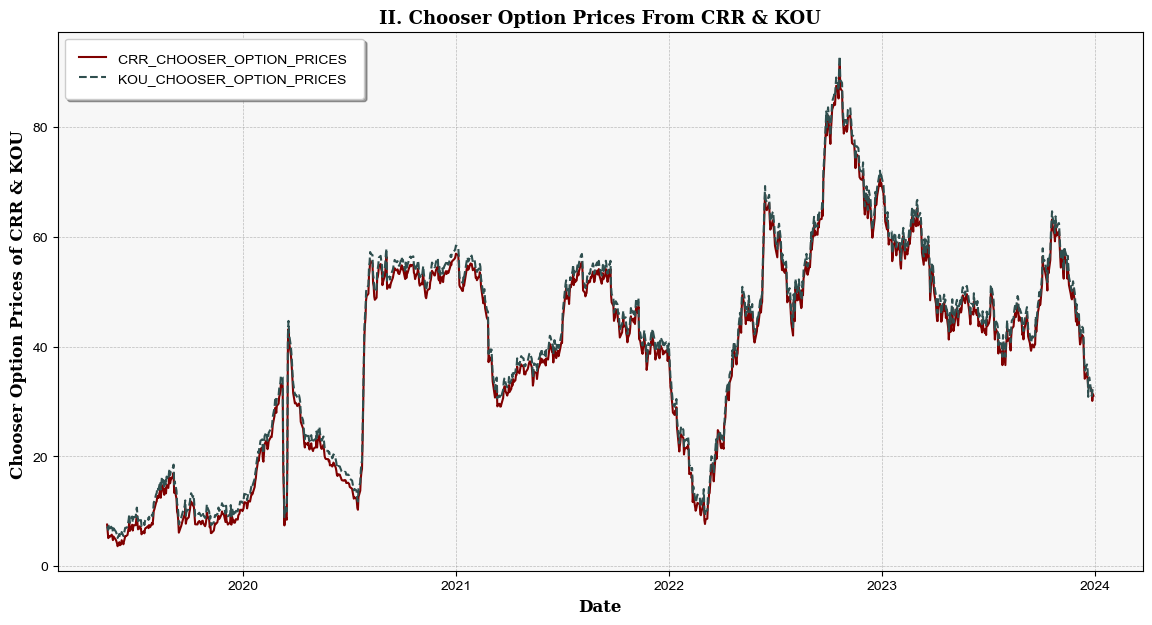

In [24]:
plt.figure(figsize=(14, 7))
plt.plot(data_df.index, np.array(chooser_df['crr_option_price']), label='CRR_CHOOSER_OPTION_PRICES ', color ="maroon")
plt.plot(data_df.index, np.array(chooser_df['kou_option_price']), label='KOU_CHOOSER_OPTION_PRICES ', linestyle= '--',color ="darkslategrey")
plt.xlabel('Date',fontsize=12, fontweight='bold',fontfamily='serif')
plt.ylabel('Chooser Option Prices of CRR & KOU ',fontsize=12, fontweight='bold',fontfamily='serif')
plt.title('II. Chooser Option Prices From CRR & KOU',fontsize=13, fontweight='bold',fontfamily='serif')

# Add legend with fancy box border
plt.legend(loc='upper left', fancybox=True, framealpha=1, shadow=True, borderpad=1)

# Add grid for better readability
plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.5)

# Customize background color
plt.gca().set_facecolor('#f7f7f7')

# Set seaborn style for better aesthetics
sns.set(style="whitegrid")

# Show plot
plt.show()

In [25]:
crr_whittaker_smoother = WhittakerSmoother(lmbda=1, order=2, data_length=len(chooser_df['crr_option_price']))
crr_smoothed_temp_anom = crr_whittaker_smoother.smooth(chooser_df['crr_option_price'])

kou_whittaker_smoother = WhittakerSmoother(lmbda=3, order=2, data_length=len(chooser_df['kou_option_price']))
kou_smoothed_temp_anom = kou_whittaker_smoother.smooth(chooser_df['kou_option_price'])

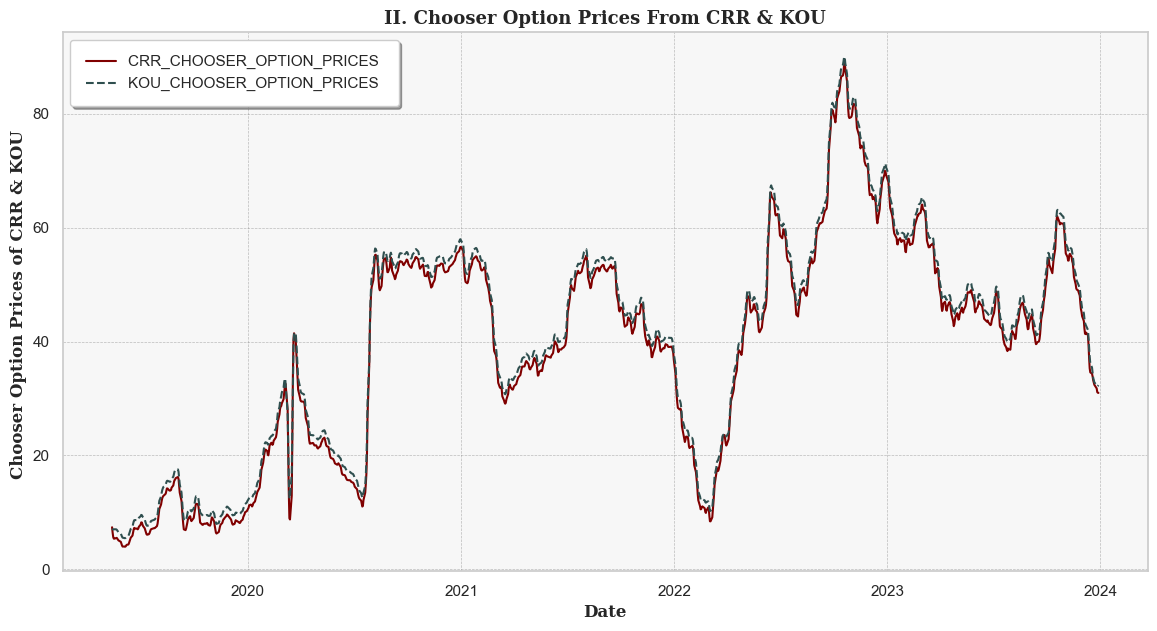

In [26]:
plt.figure(figsize=(14, 7))
plt.plot(data_df.index, np.array(crr_smoothed_temp_anom), label='CRR_CHOOSER_OPTION_PRICES ', color ="maroon")
plt.plot(data_df.index, np.array(kou_smoothed_temp_anom), label='KOU_CHOOSER_OPTION_PRICES ', linestyle= '--',color ="darkslategrey")
plt.xlabel('Date',fontsize=12, fontweight='bold',fontfamily='serif')
plt.ylabel('Chooser Option Prices of CRR & KOU ',fontsize=12, fontweight='bold',fontfamily='serif')
plt.title('II. Chooser Option Prices From CRR & KOU',fontsize=13, fontweight='bold',fontfamily='serif')

# Add legend with fancy box border
plt.legend(loc='upper left', fancybox=True, framealpha=1, shadow=True, borderpad=1)

# Add grid for better readability
plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.5)

# Customize background color
plt.gca().set_facecolor('#f7f7f7')

# Set seaborn style for better aesthetics
sns.set(style="whitegrid")

# Show plot
plt.show()

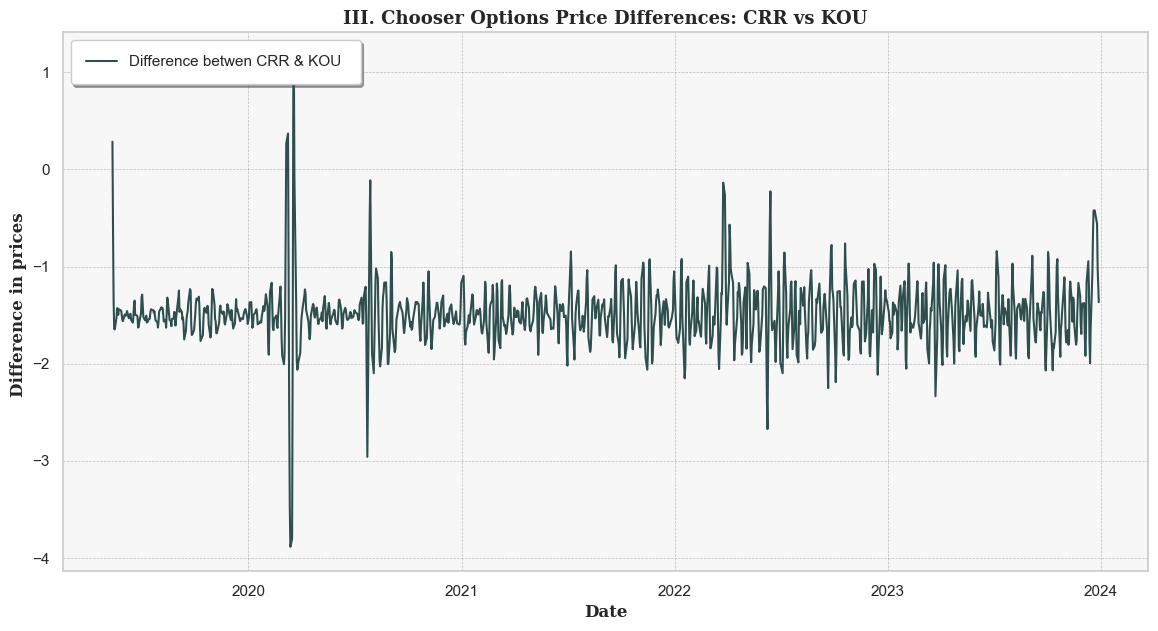

In [27]:
plt.figure(figsize=(14, 7))
plt.plot(data_df.index, np.array(crr_smoothed_temp_anom) - np.array(kou_smoothed_temp_anom), label='Difference betwen CRR & KOU ', color = 'darkslategrey')
plt.xlabel('Date',fontsize=12, fontweight='bold',fontfamily='serif')
plt.ylabel('Difference in prices ',fontsize=12, fontweight='bold',fontfamily='serif')
plt.title('III. Chooser Options Price Differences: CRR vs KOU',fontsize=13, fontweight='bold',fontfamily='serif')

# Add legend with fancy box border
plt.legend(loc='upper left', fancybox=True, framealpha=1, shadow=True, borderpad=1)

# Add grid for better readability
plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.5)

# Customize background color
plt.gca().set_facecolor('#f7f7f7')

# Set seaborn style for better aesthetics
sns.set(style="whitegrid")

# Show plot
plt.show()